# Final project GenAI

LEARNING GRADIENTS OF CONVEX FUNCTIONS WITH MONOTONE GRADIENT NETWORKS

arXiv:2301.10862v2

Librairies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import pickle
# import os

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import train_test_split

import torch
# from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

SetUp

In [3]:
# Set default tensor type to FloatTensor
torch.set_default_dtype(torch.float64)

# default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')
  
# default tensor type  
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


/home/benjamin.deporte/.conda/envs/learning_gradients/lib/python3.12/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/envs/bld/conda-bld/libtorch_1741644046984/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [4]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

### Model classes

C-MGN : Note that the nn.Parameter in PyTorch is what allows to share a weight matrix within the model

In [5]:
class CMGN(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim):
        super(CMGN, self).__init__()
        """Constructor. 
        - input_dim: int, dimension of input data
        - output_dim: int, dimension of output data
        - num_layers: int, number of layers in the model
        - hidden_dim: int, dimension of hidden layers
        """
        self.num_layers = num_layers
        # nn.ModuleList : "Holds submodules in a list" (PyTorch documentation)
        self.sigma_layers = nn.ModuleList([nn.Sigmoid() for _ in range(num_layers)])
        # nn.Parameter : "A kind of Tensor that is to be considered a module parameter." (PyTorch documentation)
        # this is how we create a weight matrix that is shared across all layers
        # NB : requires_grad=True by default
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim)) 
        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.b_L = nn.Parameter(torch.randn(output_dim))
        # nn.ParameterList : "Holds parameters in a list" (PyTorch documentation)
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_layers)])

    def forward(self, x):
        """Forward pass of the model.

        Args:
            x (tensor): input data. Shape (batch_size, input_dim)
        Returns:
            output (tensor) : output data. Shape (batch_size, output_dim)
        """

        # compute z_0
        Wx = F.linear(x, self.W)
        z = Wx + self.biases[0] 
        # compute z_1, z_2, ..., z_{L-1} with the shared weight matrix W
        for i in range(1,self.num_layers):
            z = Wx + self.sigma_layers[i-1](z) + self.biases[i]
        # compute V^T V x
        VTVx = F.linear(F.linear(x, self.V.t()), self.V)
        # compute W sigma_L
        Wsigma = F.linear(self.sigma_layers[self.num_layers-1](z), self.W.T)
        # add everything together
        output = Wsigma + VTVx + self.b_L
        
        return output

M-MGN

In [6]:
# s_k : from the paper, log cosh
def s_k(x):
    return torch.sum(torch.log(torch.cosh(x)) )

class MMGN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, hidden_dim):
        super(MMGN, self).__init__()
        """Constructor. Same wording as C-MGN
        - input_dim: int, dimension of input data
        - output_dim: int, dimension of output data
        - num_modules: int, number of modules in parallel
        - hidden_dim: int, dimension of hidden layers
        """
        self.num_modules = num_modules
        self.W_list = nn.ParameterList([nn.Parameter(torch.randn(input_dim, hidden_dim)) for _ in range(num_modules)])
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_modules)])
        # activation function : from the paper
        self.activation = nn.Tanh()

        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.a = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):

        sum = 0
        for k in range(self.num_modules):
            z_k = F.linear(x, self.W_list[k].T) + self.biases[k]
            Wsigma = F.linear(self.activation(z_k), self.W_list[k])
            sum += s_k(z) * Wsigma
        VTVx = F.linear(F.linear(x, self.V), self.V.t())

        output = self.a + VTVx + sum 
        return output

### Toy Case #1 : Gradient field experiment

Gradient field experiment from the paper.

The convex function is $f: \mathbb{R}^2 \rightarrow \mathbb{R}$:
\begin{equation}
f(x_1,x_2) = x_1^4 + \frac{x_1^2}{2} +  \frac{x_1 x_2}{2}  + \frac{3x_2^2}{2} -  \frac{x_2^3}{3}
\end{equation}

The gradient field to learn, ie the transport map, is:
\begin{equation}
T(x_1,x_2) = \begin{pmatrix}
4x_1^3 + \frac{1}{2}x_2 + x_1 \\
3x_2 - x_2^2 + \frac{1}{2}x_1
\end{pmatrix}
\end{equation}

In [7]:
def f(z):
  # convex function
  x_1 = z[:,0]
  x_2 = z[:,1]
  return torch.stack([x_1**4 + 0.5*x_1**2 + 0.5*x_1*x_2 + 3/2*x_2**2 - x_2**3/3]).T

In [8]:
def g(z):
    # gradient field
    x_1 = z[:,0]
    x_2 = z[:,1]
    return torch.stack([4*x_1**3 + 1/2*x_2 + x_1, 3*x_2 - x_2**2 + 1/2*x_1 ]).T

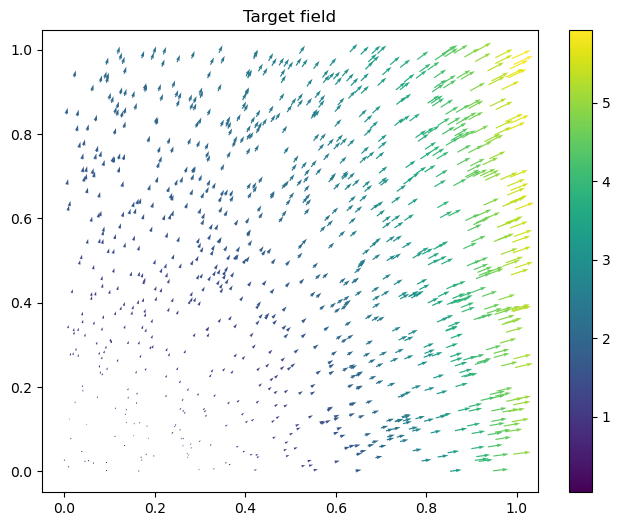

In [9]:
# Plot field (gradient)
space = torch.rand(size=(1000,2)).cpu()
fig,ax = plt.subplots(1,1,figsize=(8,6))

z = g(space)
p = ax.quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1))
ax.set_title('Target field')
plt.colorbar(p)
plt.show()

In [10]:
def train_gradient_field(mod,num_epochs=10000,dim=2,batch_size=100,lr=1e-2):
    optimizer = torch.optim.Adam(mod.parameters(),lr=lr)
    losses = []
    
    for i in range(num_epochs):
        input = torch.rand(size=(batch_size,dim))
        out = mod(input)
        target = g(input)

        loss = (out - target).abs().sum() / batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i % 1000: 
            print(f"epoch {i}/{num_epochs}, loss = {loss.item():4e}", end="\r")
        losses.append(loss.item())
        
    return losses

In [ ]:
model_MMGN = MMGN(input_dim=2, output_dim=2, num_modules=1, hidden_dim=4)
model_CMGN = CMGN(input_dim=2, output_dim=2, num_layers=2, hidden_dim=2)

dim = 2
bsize = 100
epochs_cmgn = 40000
epochs_mmgn = 40000

print("Training C-MGN...")
# summary_model(model_CMGN)
losses_cmgn = train_gradient_field(model_CMGN,num_epochs=epochs_cmgn,dim=dim,batch_size=bsize)

print()
print("Training M-MGN...")
# summary_model(model_MMGN)
losses_mmgn = train_gradient_field(model_MMGN,num_epochs=epochs_mmgn,dim=dim,batch_size=bsize, lr=1e-4)

Training C-MGN...
epoch 99000/100000, loss = 2.409798e-02
Training M-MGN...


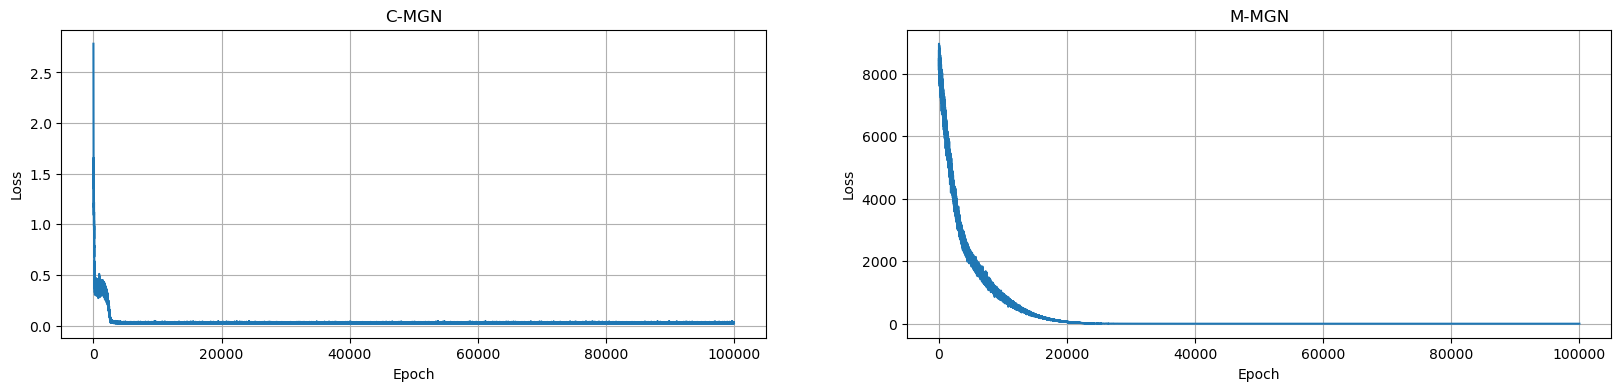

In [12]:
# display training losses
fig, ax = plt.subplots(1,2,figsize=(20,4))

ax[0].plot(losses_cmgn)
ax[0].set_title("C-MGN")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(losses_mmgn)
ax[1].set_title("M-MGN")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].grid()

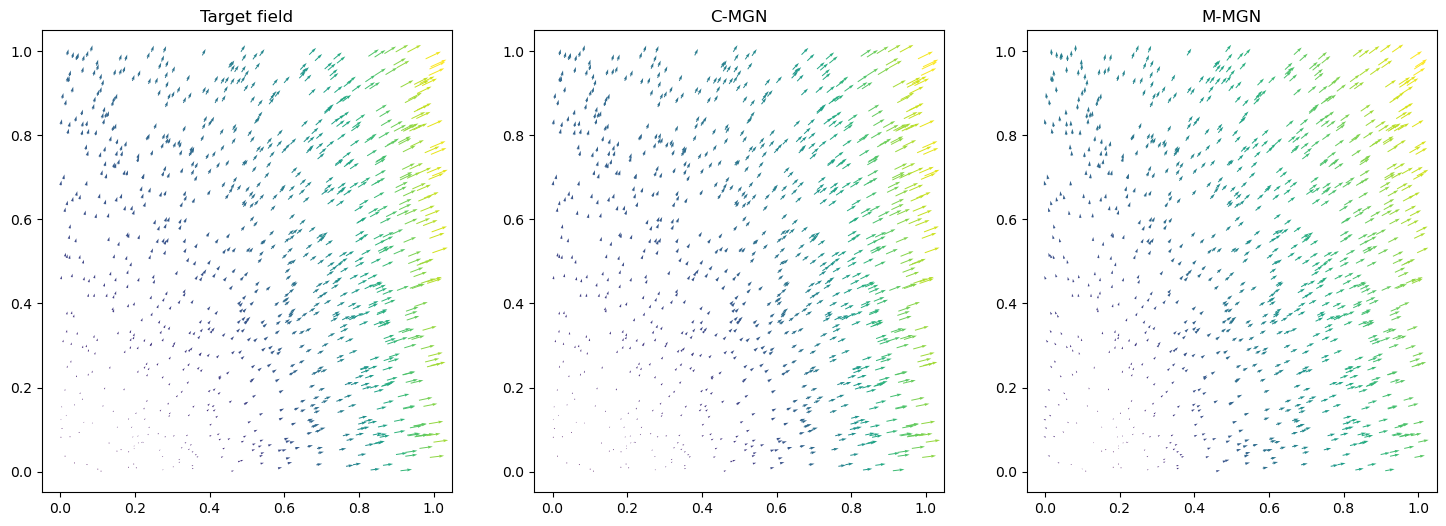

In [13]:
# Visualize the learned fields
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

# calculate fields
space = torch.rand(size=(1000,2)).to(device)
z = g(space)
z_c = model_CMGN(space)
z_m = model_MMGN(space)

# move to cpu for plotting
space = space.cpu()
z = z.cpu()
z_c = z_c.detach().cpu()
z_m = z_m.detach().cpu()

# true gradient field
z = g(space).cpu()
p = axs[0].quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1))
axs[0].set_title('Target field')
# axs[0].colorbar(p)

# C-MGN
p = axs[1].quiver(space[:,0],space[:,1], z_c[:,0],z_c[:,1],z_c.norm(dim=1))
axs[1].set_title('C-MGN')
# axs[1].colorbar(p)

# M-MGN
p = axs[2].quiver(space[:,0],space[:,1], z_m[:,0],z_m[:,1],z_m.norm(dim=1))
axs[2].set_title('M-MGN')
# axs[2].colorbar(p)

plt.show()

### Toy Case 2 : Transporting one Gaussian to another

We want to transport a source 2D Gaussian $\mathcal{N}(\mu_s, \Sigma_s)$ to a destination 2D Gaussian $\mathcal{N}(\mu_d, \Sigma_d)$.

The transport is learnt by the models C-MGN and M-MGN with the following losses:
- Wasserstein distance
- KL divergence

We also compute the transport cost.

In [134]:
# source distribution
mu_s = torch.tensor([0.,0.])
cov_s = torch.tensor([[2.,0.],[0.,2.]])

# target distribution
mu_t = torch.tensor([-2.,-2.])
diag_t = torch.tensor([[3.0, 0.0],[0.0, 0.01]])
theta = -torch.tensor(torch.pi/3)
rot_t = torch.tensor([[torch.cos(theta), -torch.sin(theta)],[torch.sin(theta), torch.cos(theta)]])
cov_t = torch.mm(torch.mm(rot_t,diag_t),rot_t.t())

print(f"covariance target: {cov_t}")

covariance target: tensor([[ 0.7575, -1.2947],
        [-1.2947,  2.2525]])


In [135]:
def sample_gaussian(mu, cov, n_samples):
    # using torch.distributions to get n samples from the Gaussian mu,cov
    return torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=cov).sample((n_samples,))

In [136]:
def two_plots(z_1, z_2, name_1="source", name_2="current"):
    """Utility function to display the two Gaussians side by side.

    Args:
    z_1 (torch.tensor, shape n x 2): points Gaussian 1
    z_2 (torch.tensor, shape n x 2): points Gaussian 2
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].scatter(z_1[:, 0], z_1[:, 1], s=5)
    axs[0].set_title(name_1)
    axs[0].set_xlim(-5, 5)
    axs[0].set_ylim(-5, 5)
    axs[0].grid()

    axs[1].scatter(z_2[:, 0], z_2[:, 1], s=5)
    axs[1].set_title(name_2)
    axs[1].set_xlim(-5, 5)
    axs[1].set_ylim(-5, 5)
    axs[1].grid()

    plt.show()

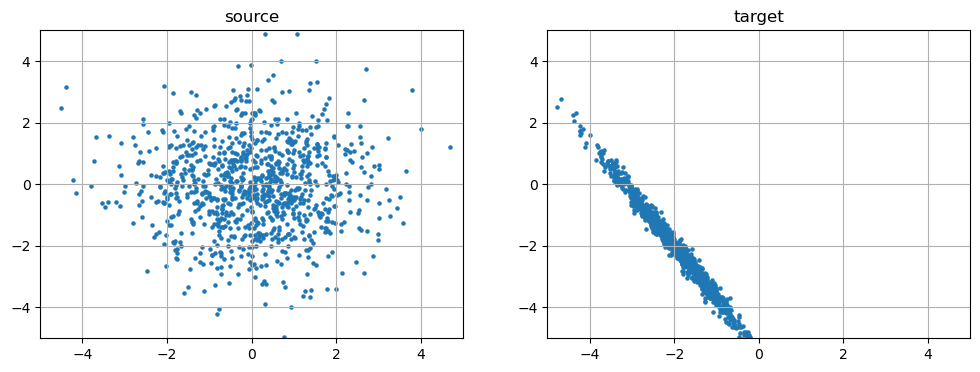

In [137]:
z_1 = sample_gaussian(mu_s, cov_s, 1000).cpu()
z_2 = sample_gaussian(mu_t, cov_t, 1000).cpu()
two_plots(z_1, z_2, name_2='target')

Wasserstein 2 distance between two Gaussians $\mathcal{N}_1(\mu_1, \Sigma_1)$ and $\mathcal{N}_2(\mu_2, \Sigma_2)$:

\begin{align*}
\mathcal{W}(\mathcal{N}_1, \mathcal{N}_2) = \vert\vert \mu_1 - \mu_2 \vert\vert_2^2 + \text{Trace} \,\, \left( \Sigma_1 + \Sigma_2 - 2*(\Sigma_2^{\frac{1}{2}} \Sigma_1 \Sigma_2^{\frac{1}{2}})^{\frac{1}{2}}
    \right)
\end{align*}

In [138]:
def wasserstein_2(mu1, mu2, sigma1, sigma2):
    """Compute the 2-Wasserstein distance between two Gaussians.

    Args:
    mu1 (torch.tensor, shape 2): mean of Gaussian 1
    mu2 (torch.tensor, shape 2): mean of Gaussian 2
    sigma1 (torch.tensor, shape 2 x 2): covariance of Gaussian 1
    sigma2 (torch.tensor, shape 2 x 2): covariance of Gaussian 2

    Returns:
    float: 2-Wasserstein distance
    """
    U, S, Vt = torch.linalg.svd(sigma2)  # sigma 2 = U @ S @ Vt
    racine_sigma2 = torch.mm(torch.mm(U, torch.diag(torch.sqrt(S))), Vt) # sigma2^0.5 = U @ S^0.5 @ Vt
    A = torch.mm(torch.mm(racine_sigma2, sigma1),racine_sigma2) # A = sigma2^0.5 @ sigma1 @ sigma2^0.5
    Ua, Sa, Vta = torch.linalg.svd(A)
    racine_A = torch.mm(torch.mm(Ua, torch.diag(torch.sqrt(Sa))), Vta)
    
    w = torch.sum((mu1-mu2)**2) + torch.trace(sigma1 + sigma2 - 2*racine_A)
    
    return w

KL-Divergence between two Gaussians $\mathcal{N}_1(\mu_1, \Sigma_1)$ and $\mathcal{N}_2(\mu_2, \Sigma_2)$:

\begin{align*}
\mathbb{KL}(\mathcal{N}_1 \vert\vert \mathcal{N}_2) = \frac{1}{2}\left(
    \text{Trace}(\Sigma_2^{-1}\Sigma_1) - k + (\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1) + \text{ln}(\frac{\vert \Sigma_2 \vert}{\vert \Sigma_1 \vert}
    \right)
\end{align*}

where $k$ is the dimensionnality of the two Gaussians

In [146]:
def KL(mu1, mu2, sigma1, sigma2):
    """Compute the Kullback-Leibler divergence between two Gaussians.
    """
    k = mu1.shape[0]  # Dimensionality of the distributions
    sigma2_inv = torch.linalg.inv(sigma2)  # not a ood practice to compute the inverse, but ok for the toy case
    
    kl = 1/2 * (torch.trace(sigma2_inv @ sigma1) - k + (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1) + torch.log(torch.linalg.det(sigma2) / torch.linalg.det(sigma1)))
    
    return kl

Training loop

In [ ]:
def train_OT(
    model,  # model to train
    loss_function,  # loss function (either W2 or KL)
    mu_s,  # source distribution mean
    cov_s,  # source distribution covariance
    mu_t,  # target distribution mean
    cov_t,  # target distribution covariance
    num_epochs=5000,  # number of training epochs
    batch_size=1000,  # batch size
    lr=1e-2,  # learning rate
    model_name=None,  # name of the model
    display_frequency=500,  # display frequency
):
    """Train a model to minimize the 2-Wasserstein distance between two Gaussians.

    Args:
    model (nn.Module): model to train
    loss_function (function): either W2 or KL - takes mu1, mu2, sigma1, sigma2 as input
    mu_s (torch.tensor, shape 2): mean of the source distribution
    cov_s (torch.tensor, shape 2 x 2): covariance of the source distribution
    mu_t (torch.tensor, shape 2): mean of the target distribution
    cov_t (torch.tensor, shape 2 x 2): covariance of the target distribution
    num_epochs (int): number of training epochs
    batch_size (int): batch size
    lr (float): learning rate

    Returns:
    list: list of losses
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    norms_delta_mu = []
    norms_delta_cov = []
    transport_costs = []

    for i in range(num_epochs):
        # source distribution
        z_s = sample_gaussian(mu_s, cov_s, batch_size)
        # target distribution
        z_t = sample_gaussian(mu_t, cov_t, batch_size)

        # compute the current transport of the source distribution by the model
        z_s = z_s.to(device)
        z_model = model(z_s)
        mu_model = z_model.mean(dim=0)
        cov_model = torch.mm((z_model - mu_model).T, z_model - mu_model) / batch_size

        # compute the loss wrt the target distribution
        loss = loss_function(mu_t, mu_model, cov_t, cov_model)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute deltas and logs
        norm_delta_mu = torch.norm(mu_t - mu_model).item()
        norm_delta_cov = torch.norm(cov_t - cov_model).item()
        transport_cost = torch.mean((z_model - z_s)**2).item()
        
        losses.append(loss.item())
        norms_delta_mu.append(norm_delta_mu)
        norms_delta_cov.append(norm_delta_cov)
        transport_costs.append(transport_cost)
        
        # donne des nouvelles
        if not i % display_frequency:
            print(f"epoch {i}/{num_epochs}, loss = {loss.item():2e}")
            print(f"delta between mus = {torch.norm(mu_t - mu_model).item():.2e}")
            print(f"delta between covs = {torch.norm(cov_t - cov_model).item():.2e}")
            print(f"transport cost = {transport_cost:.2e}")
            print(f"mu model = {mu_model:.2e}")
            print(f"cov model = {cov_model:.2e}")
            print()
        
        # visualize transport
        if not i % display_frequency:
            two_plots(z_t.cpu(), z_model.detach().cpu(), name_1="target", name_2=model_name + f" @ epoch {i}")

    return losses, norms_delta_mu, norms_delta_cov, transport_costs

In [154]:
def plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs):
    """Plot the metrics computed during training.

    Args:
    losses (list): list of losses
    norms_delta_mu (list): list of norms of deltas between mus
    norms_delta_cov (list): list of norms of deltas between covs
    transport_costs (list): list of transport costs
    """
    width = 5
    fig, axs = plt.subplots(1, 4, figsize=(width*4, 4))

    axs[0].plot(losses)
    axs[0].set_title("Training loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_yscale("log")
    # axs[0].set_ylabel("Loss")
    axs[0].grid()

    axs[1].plot(norms_delta_mu)
    axs[1].set_title("Norm of delta mu")
    axs[1].set_xlabel("Epoch")
    axs[1].set_yscale("log")
    # axs[1].set_ylabel("Norm")
    axs[1].grid()

    axs[2].plot(norms_delta_cov)
    axs[2].set_title("Norm of delta cov")
    axs[2].set_xlabel("Epoch")
    axs[2].set_yscale("log")
    # axs[2].set_ylabel("Norm")
    axs[2].grid()
    
    axs[3].plot(norms_delta_cov)
    axs[3].set_title("Euclidian transport cost")
    axs[3].set_xlabel("Epoch")
    axs[3].set_yscale("log")
    # axs[2].set_ylabel("Norm")
    axs[3].grid()

    plt.show()

### Training networks and learning transport with the Wasserstein-2 distance

C-MGN

Training C-MGN...
epoch 0/3000, loss = 6.045578e+01
delta between mus = 3.4905644152362845
delta between covs = 66.62800306187336
transport cost = 24.32419460964941
mu model = tensor([0.5675, 0.3647], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.8019,  6.4825],
        [ 6.4825, 67.9664]], grad_fn=<DivBackward0>)



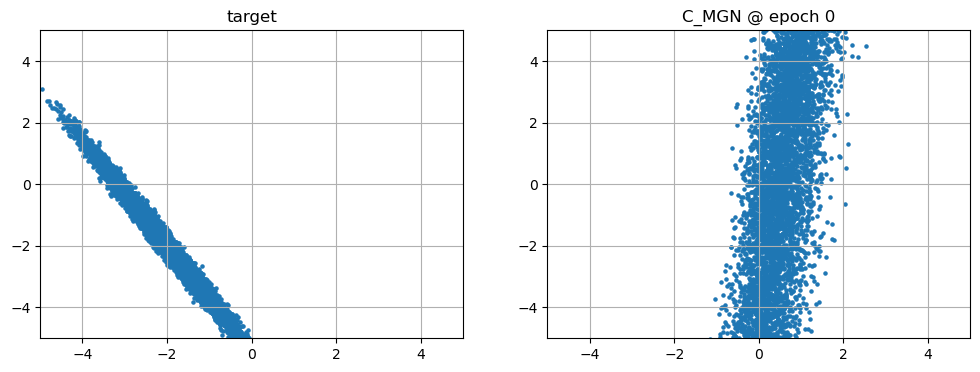

epoch 500/3000, loss = 1.598983e-02
delta between mus = 0.043390988390842454
delta between covs = 0.1815322430059347
transport cost = 4.786029259842191
mu model = tensor([-1.9966, -1.9567], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7446, -1.2976],
        [-1.2976,  2.4335]], grad_fn=<DivBackward0>)



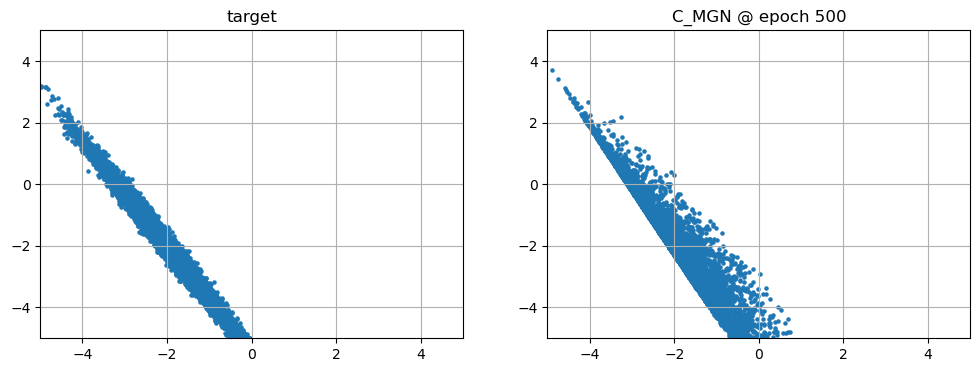

epoch 1000/3000, loss = 2.132529e-03
delta between mus = 0.011463463965006986
delta between covs = 0.07299523802360375
transport cost = 4.913967138724871
mu model = tensor([-1.9886, -2.0009], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7935, -1.3275],
        [-1.3275,  2.2959]], grad_fn=<DivBackward0>)



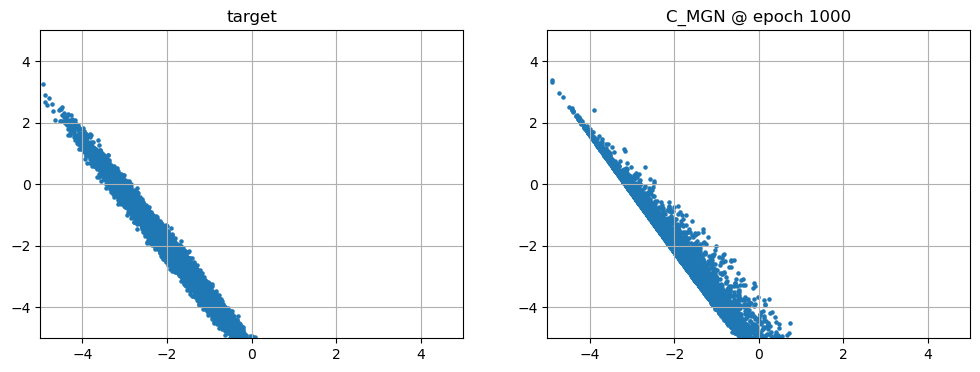

epoch 1500/3000, loss = 3.347037e-04
delta between mus = 0.000994166418933849
delta between covs = 0.05266486698921101
transport cost = 4.9105350505244
mu model = tensor([-1.9990, -2.0000], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7431, -1.2694],
        [-1.2694,  2.2166]], grad_fn=<DivBackward0>)



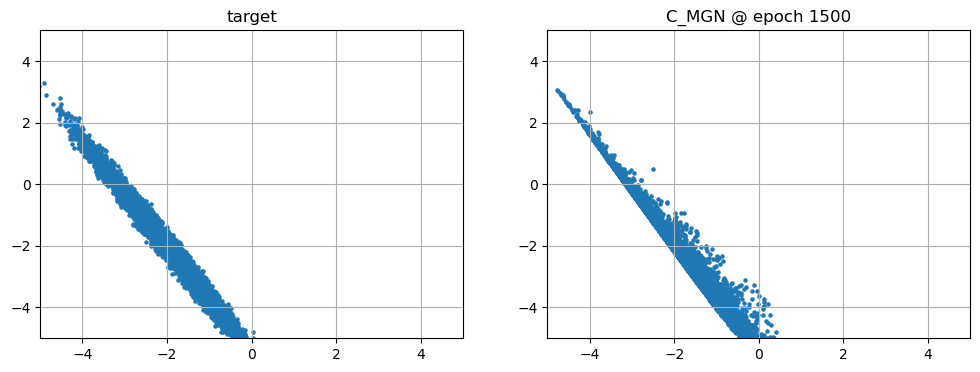

epoch 2000/3000, loss = 9.620893e-04
delta between mus = 0.030838962821369685
delta between covs = 0.010290495791645435
transport cost = 4.939526489522273
mu model = tensor([-1.9847, -2.0268], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7625, -1.3001],
        [-1.3001,  2.2572]], grad_fn=<DivBackward0>)



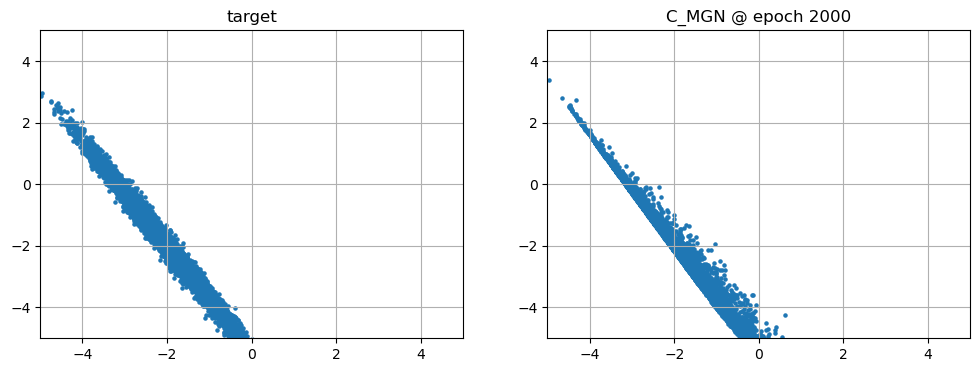

epoch 2500/3000, loss = 1.202539e-03
delta between mus = 0.03429274105469525
delta between covs = 0.013530676775106618
transport cost = 5.0139326732610465
mu model = tensor([-1.9803, -2.0281], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7663, -1.3020],
        [-1.3020,  2.2524]], grad_fn=<DivBackward0>)



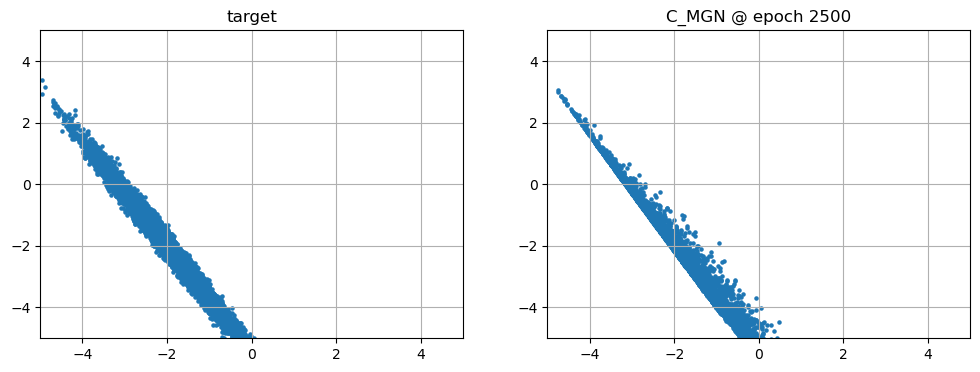

In [150]:
model_CMGN = CMGN(input_dim=2, output_dim=2, num_layers=2, hidden_dim=2)

print("Training C-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_CMGN, 
    wasserstein_2, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=3000, 
    batch_size=10000,
    model_name='C_MGN'
    )

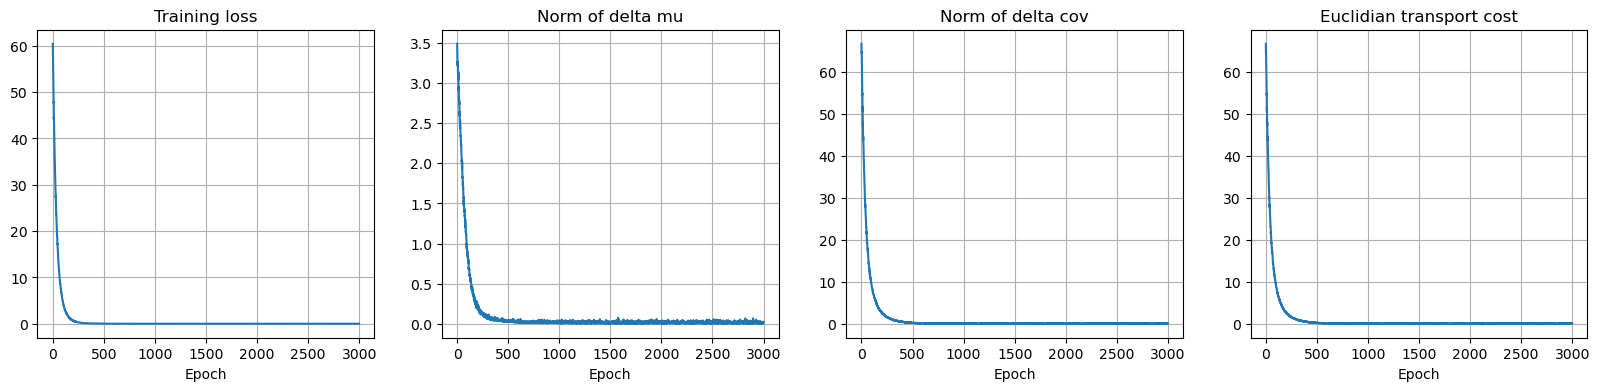

In [151]:
plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs)

M-MGN

Training M-MGN...
epoch 0/30000, loss = 2.418502e+07
delta between mus = 1387.8882092695223
delta between covs = 16754200.8215261
transport cost = 12087154.441841163
mu model = tensor([ 678.7800, 1207.4512], grad_fn=<MeanBackward1>)
cov model = tensor([[ 9719122.9678, -3784679.5768],
        [-3784679.5768, 12553660.2545]], grad_fn=<DivBackward0>)



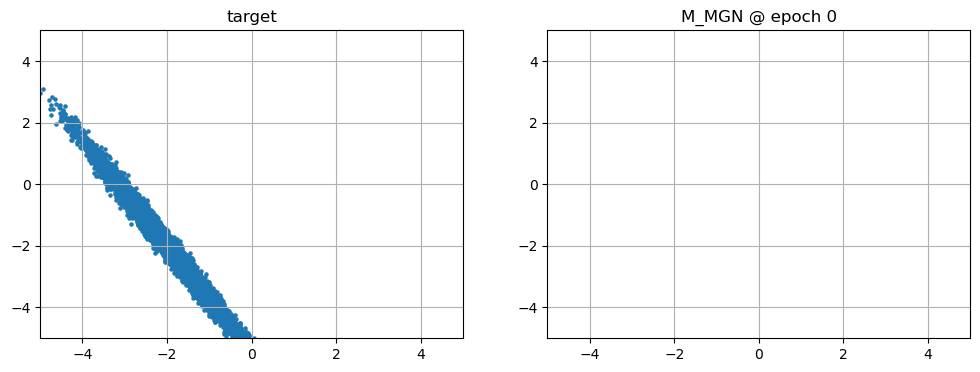

epoch 5000/30000, loss = 2.572045e+01
delta between mus = 0.4528279722541236
delta between covs = 24.930631155277734
transport cost = 13.573383311471297
mu model = tensor([-2.4519, -1.9711], grad_fn=<MeanBackward1>)
cov model = tensor([[20.1149,  2.2739],
        [ 2.2739, 17.1305]], grad_fn=<DivBackward0>)



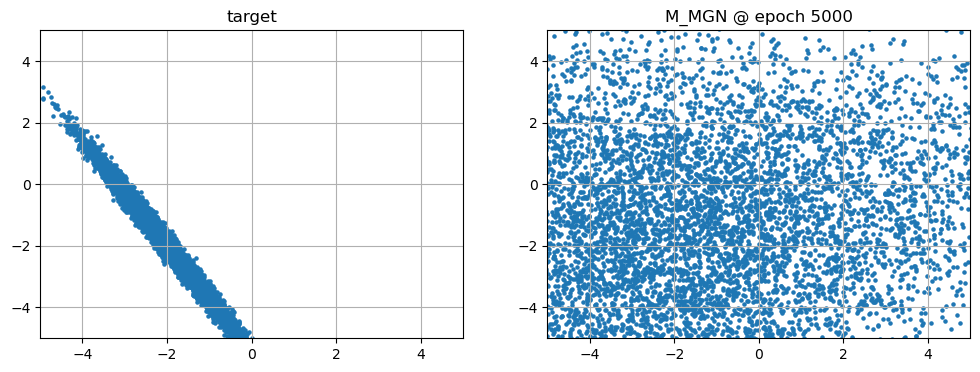

epoch 10000/30000, loss = 6.334486e+00
delta between mus = 2.4257762104852145
delta between covs = 0.6778198506490897
transport cost = 11.991488113077178
mu model = tensor([-1.9089, -4.4241], grad_fn=<MeanBackward1>)
cov model = tensor([[ 1.2685, -1.1988],
        [-1.1988,  2.6767]], grad_fn=<DivBackward0>)



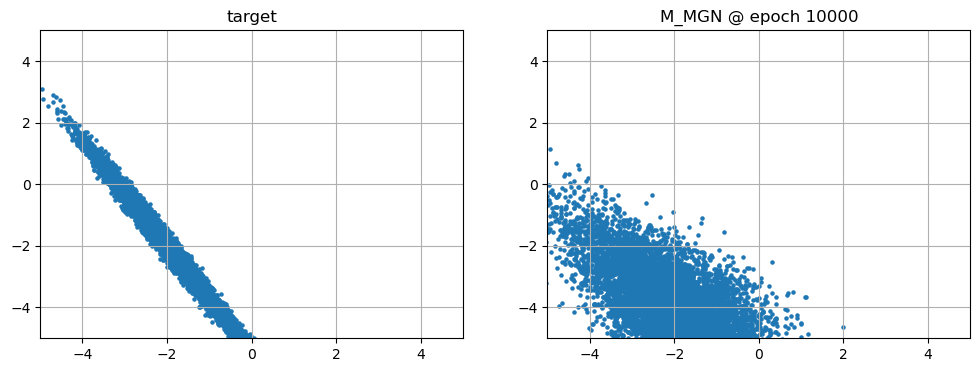

epoch 15000/30000, loss = 3.588835e+01
delta between mus = 5.9889554181815345
delta between covs = 0.05579891208154163
transport cost = 34.08681203511446
mu model = tensor([-7.9855, -1.7970], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7861, -1.2729],
        [-1.2729,  2.2892]], grad_fn=<DivBackward0>)



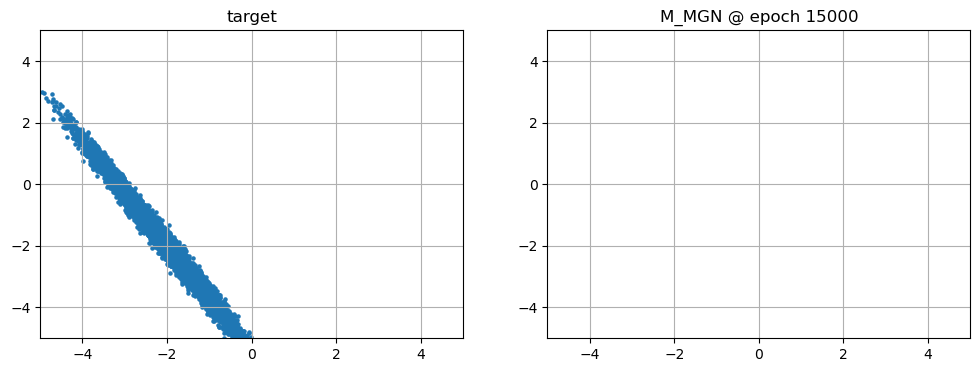

epoch 20000/30000, loss = 2.564288e+00
delta between mus = 1.5989408631092514
delta between covs = 0.09440795273242465
transport cost = 6.434234805286173
mu model = tensor([-3.2058, -0.9500], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7897, -1.3188],
        [-1.3188,  2.3344]], grad_fn=<DivBackward0>)



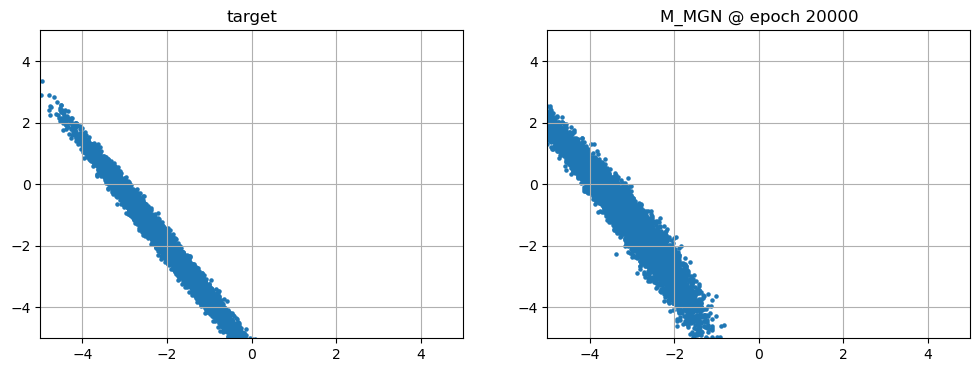

epoch 25000/30000, loss = 6.686814e-02
delta between mus = 0.23784764456643226
delta between covs = 0.10555915262152485
transport cost = 5.221029526553383
mu model = tensor([-2.2363, -1.9727], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.8002, -1.3236],
        [-1.3236,  2.3400]], grad_fn=<DivBackward0>)



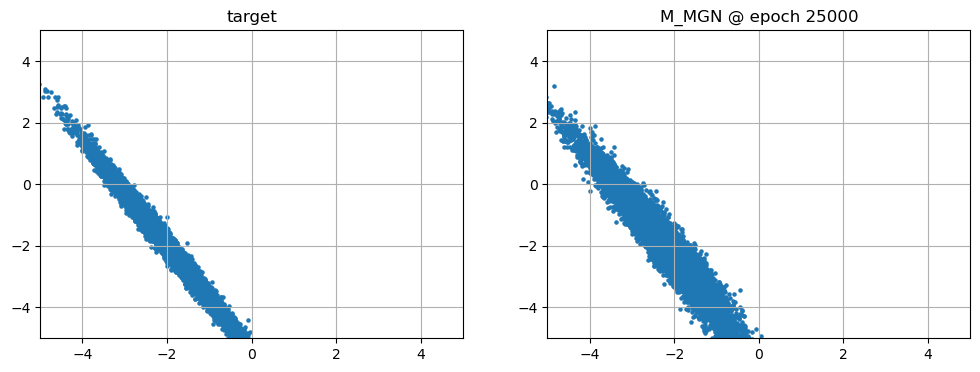

In [152]:
model_MMGN = MMGN(input_dim=2, output_dim=2, num_modules=2, hidden_dim=2)

print("Training M-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_MMGN, 
    wasserstein_2, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=30000, 
    batch_size=10000,
    model_name='M_MGN',
    display_frequency=5000
    )

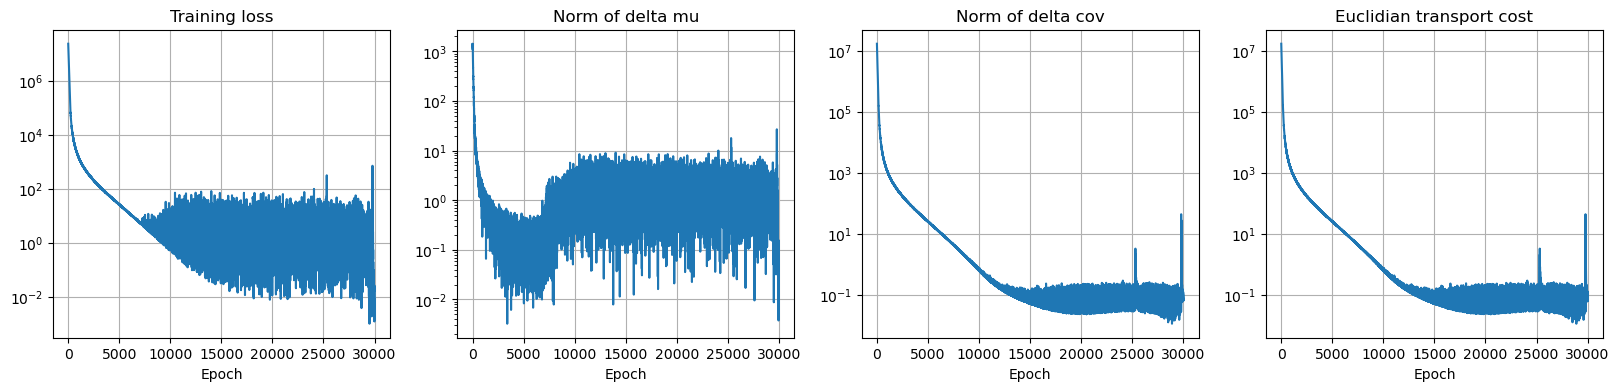

In [155]:
plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs)

### Training networks and learning transport with the KL divergence

C-MGN

Training C-MGN...
epoch 0/3000, loss = 3.553314e+01
delta between mus = 3.4631007727332035
delta between covs = 18.075429140262358
transport cost = 5.618616664731893
mu model = tensor([-0.7506,  1.2299], grad_fn=<MeanBackward1>)
cov model = tensor([[12.8527,  7.9859],
        [ 7.9859,  5.1100]], grad_fn=<DivBackward0>)



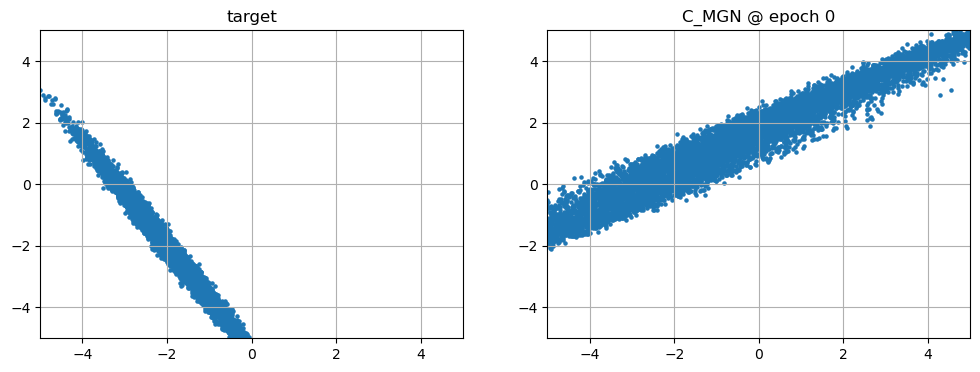

epoch 500/3000, loss = 2.924125e+00
delta between mus = 2.017079561561514
delta between covs = 6.129190336370565
transport cost = 1.2383408100272308
mu model = tensor([-0.9476, -0.2792], grad_fn=<MeanBackward1>)
cov model = tensor([[2.5800, 1.6529],
        [1.6529, 6.3596]], grad_fn=<DivBackward0>)



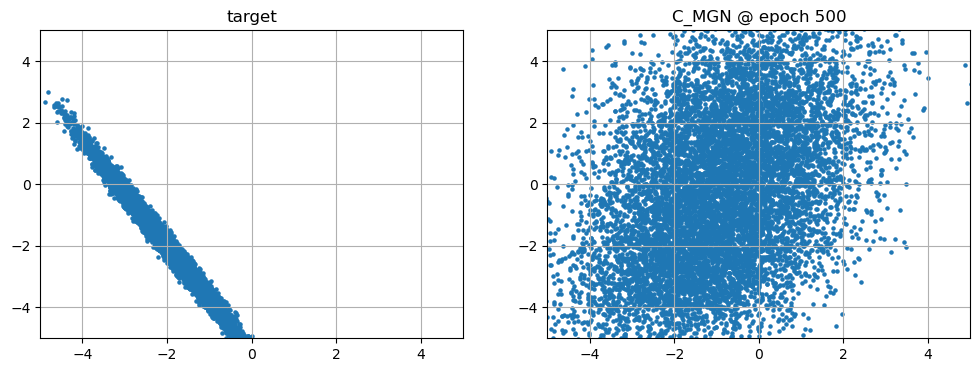

epoch 1000/3000, loss = 2.215916e-02
delta between mus = 0.32914396954663744
delta between covs = 0.5503776910627405
transport cost = 4.820593114682512
mu model = tensor([-2.1631, -1.7141], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.8959, -1.5334],
        [-1.5334,  2.6645]], grad_fn=<DivBackward0>)



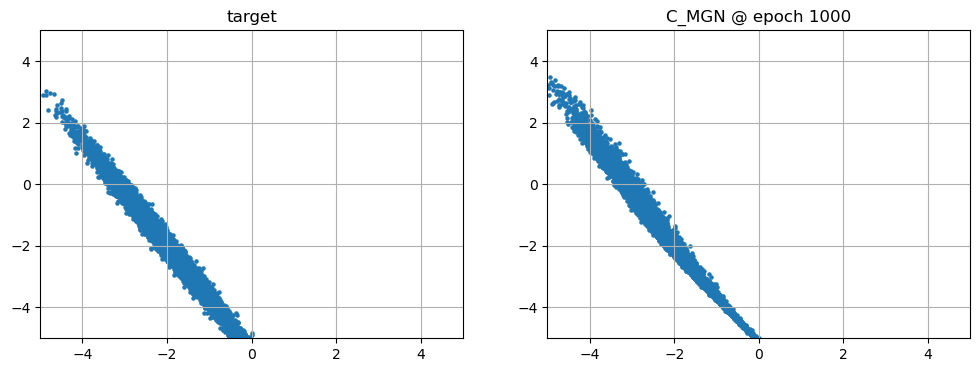

epoch 1500/3000, loss = 1.754635e-04
delta between mus = 0.004375158113786963
delta between covs = 0.0031603631662125266
transport cost = 4.967058597406383
mu model = tensor([-2.0023, -1.9963], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7596, -1.2964],
        [-1.2964,  2.2528]], grad_fn=<DivBackward0>)



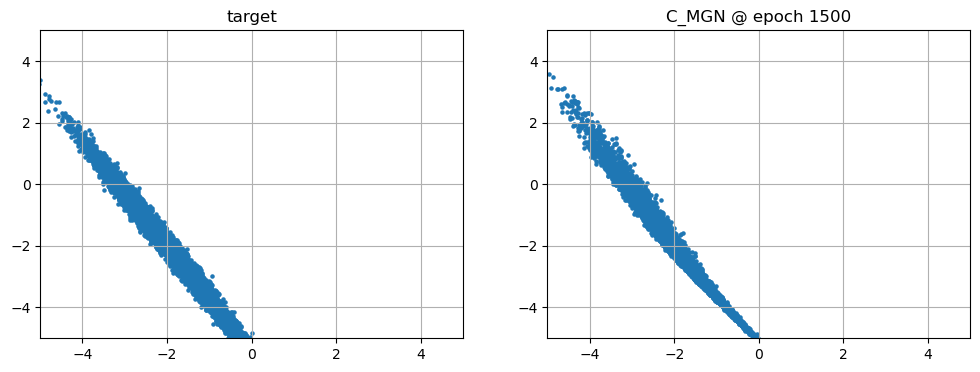

epoch 2000/3000, loss = 4.642148e-04
delta between mus = 0.037127792202387676
delta between covs = 0.05541419956455494
transport cost = 4.9042041605480975
mu model = tensor([-2.0199, -1.9686], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7428, -1.2702],
        [-1.2702,  2.2118]], grad_fn=<DivBackward0>)



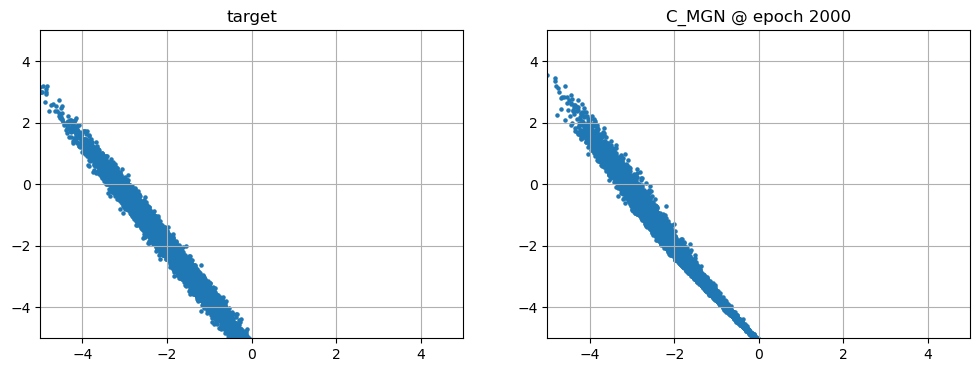

epoch 2500/3000, loss = 1.094156e-03
delta between mus = 0.006943477352365733
delta between covs = 0.06296214830083005
transport cost = 4.926587579077366
mu model = tensor([-1.9952, -2.0050], grad_fn=<MeanBackward1>)
cov model = tensor([[ 0.7791, -1.3250],
        [-1.3250,  2.2933]], grad_fn=<DivBackward0>)



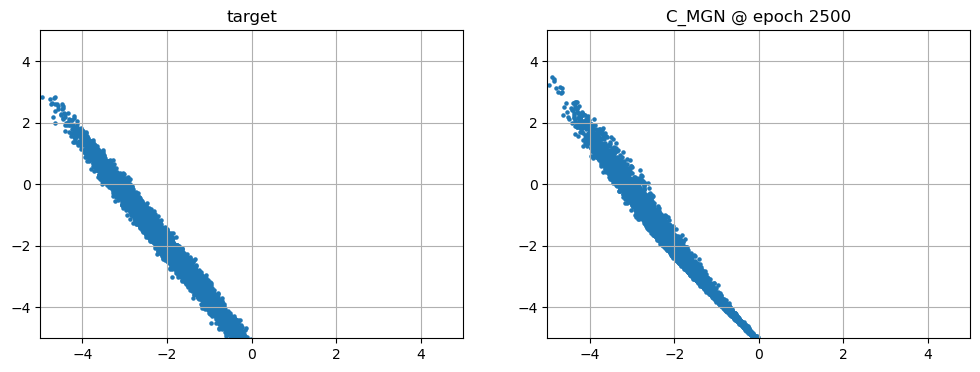

In [156]:
model_CMGN = CMGN(input_dim=2, output_dim=2, num_layers=2, hidden_dim=2)

print("Training C-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_CMGN, 
    KL, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=3000, 
    batch_size=10000,
    model_name='C_MGN'
    )

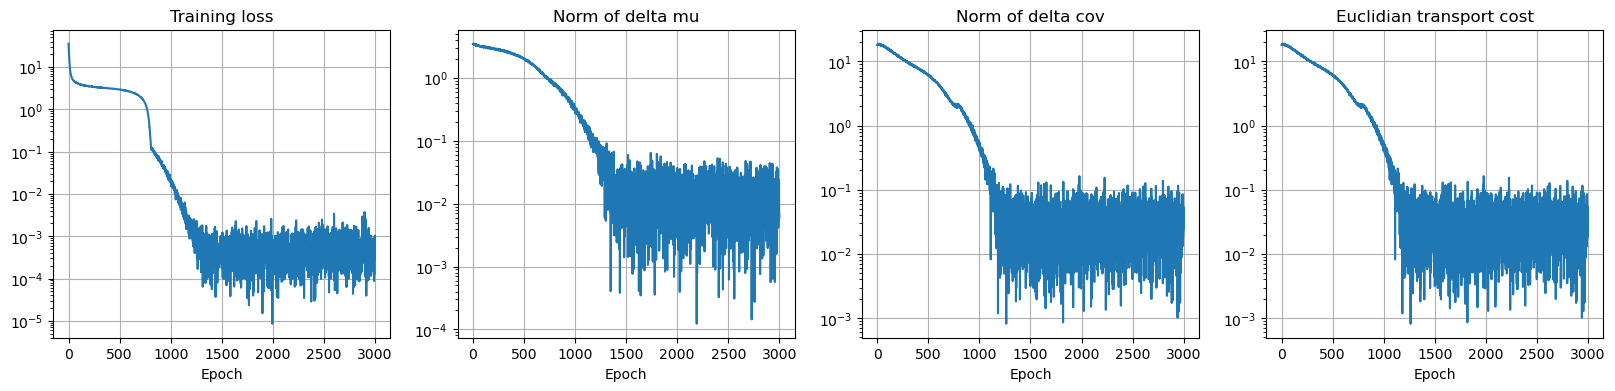

In [157]:
plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs)

M-MGN

Training M-MGN...
epoch 0/30000, loss = 1.700705e+01
delta between mus = 1702.571735057735
delta between covs = 17370839.45098085
transport cost = 12796704.241833424
mu model = tensor([-1324.1008, -1074.7535], grad_fn=<MeanBackward1>)
cov model = tensor([[ 9414588.0071,  4274810.8109],
        [ 4274810.8109, 13287724.8969]], grad_fn=<DivBackward0>)



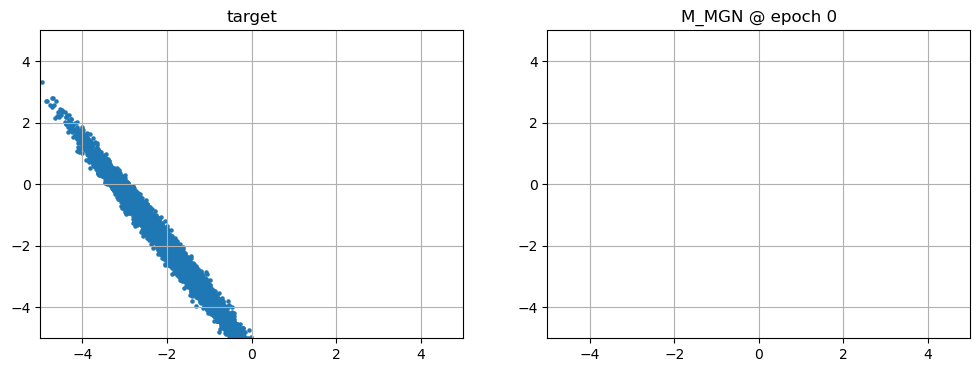

epoch 5000/30000, loss = 6.165870e+00
delta between mus = 8.861216487961604
delta between covs = 35.610572249149044
transport cost = 80.18676035347998
mu model = tensor([ -3.9449, -10.6451], grad_fn=<MeanBackward1>)
cov model = tensor([[32.5418, -1.4916],
        [-1.4916, 18.3084]], grad_fn=<DivBackward0>)



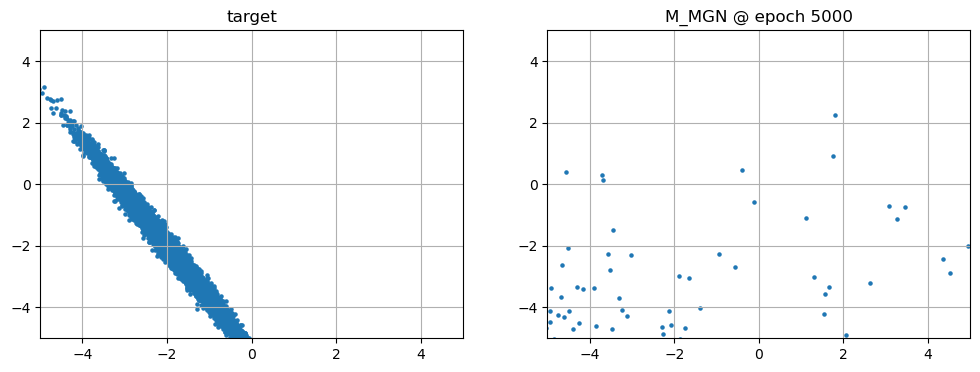

epoch 10000/30000, loss = 3.356771e+00
delta between mus = 0.5679224687258919
delta between covs = 14.76271459690119
transport cost = 10.794796246944596
mu model = tensor([-2.3517, -2.4459], grad_fn=<MeanBackward1>)
cov model = tensor([[12.0895,  1.0211],
        [ 1.0211, 11.1293]], grad_fn=<DivBackward0>)



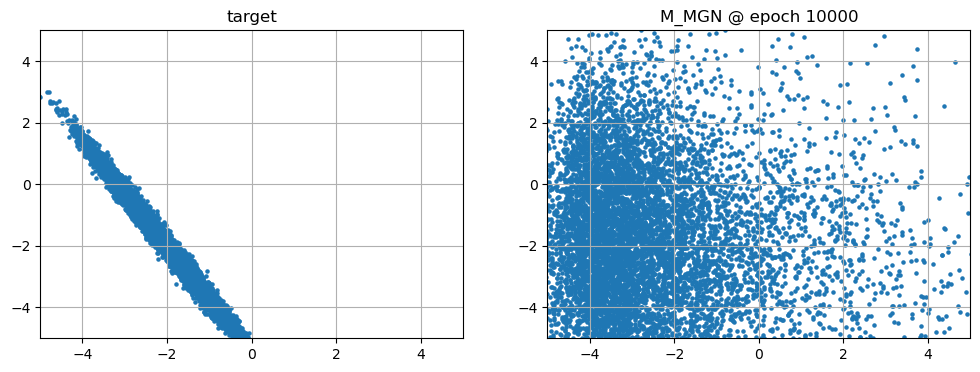

epoch 15000/30000, loss = 3.447359e+00
delta between mus = 0.831925654361752
delta between covs = 16.21632911506824
transport cost = 8.13593482157801
mu model = tensor([-1.9644, -1.1688], grad_fn=<MeanBackward1>)
cov model = tensor([[13.6829,  0.6495],
        [ 0.6495, 11.6516]], grad_fn=<DivBackward0>)



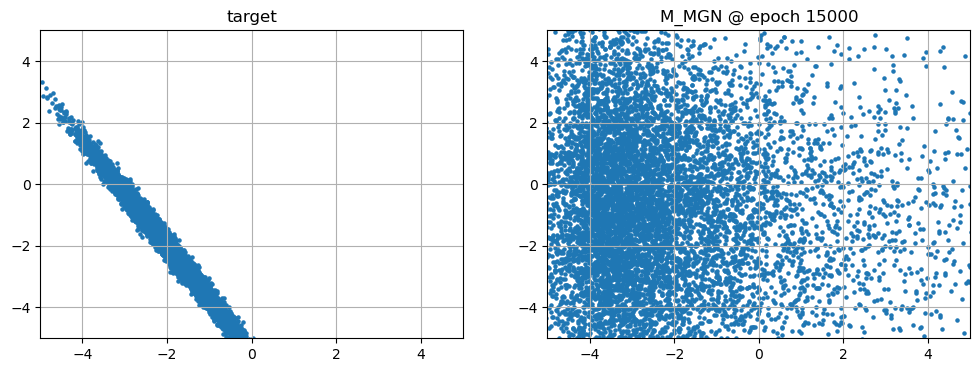

epoch 20000/30000, loss = 5.608750e+00
delta between mus = 7.89390992847412
delta between covs = 674.5050915949333
transport cost = 364.56613359463825
mu model = tensor([-9.8602, -1.2717], grad_fn=<MeanBackward1>)
cov model = tensor([[673.3051,  32.7964],
        [ 32.7964,  19.9295]], grad_fn=<DivBackward0>)



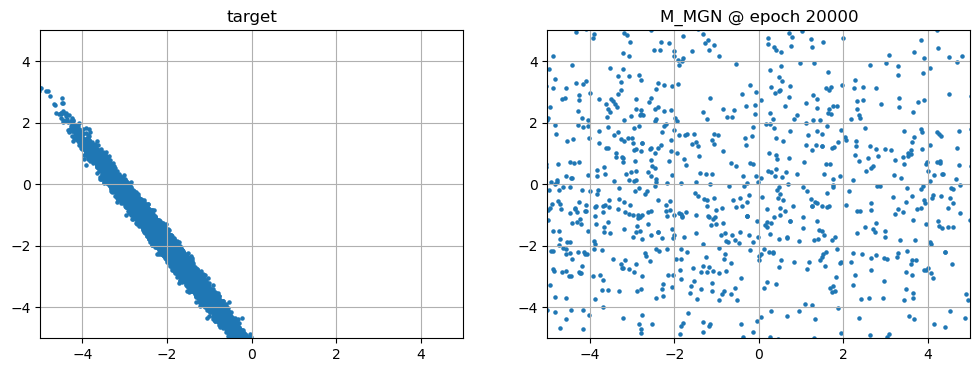

epoch 25000/30000, loss = 3.475440e+00
delta between mus = 0.2922984202585545
delta between covs = 19.40347244448423
transport cost = 10.839608019905585
mu model = tensor([-2.2501, -1.8487], grad_fn=<MeanBackward1>)
cov model = tensor([[ 9.7639,  0.3815],
        [ 0.3815, 19.2748]], grad_fn=<DivBackward0>)



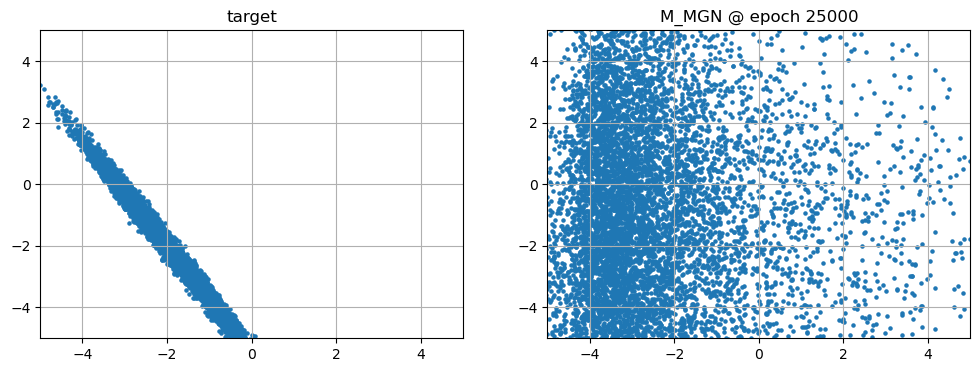

In [158]:
model_MMGN = MMGN(input_dim=2, output_dim=2, num_modules=2, hidden_dim=2)

print("Training M-MGN...")
losses, norms_delta_mu, norms_delta_cov, transport_costs = train_OT(
    model_MMGN, 
    KL, 
    mu_s, cov_s, 
    mu_t, cov_t, 
    num_epochs=30000, 
    batch_size=10000,
    model_name='M_MGN',
    display_frequency=5000
    )

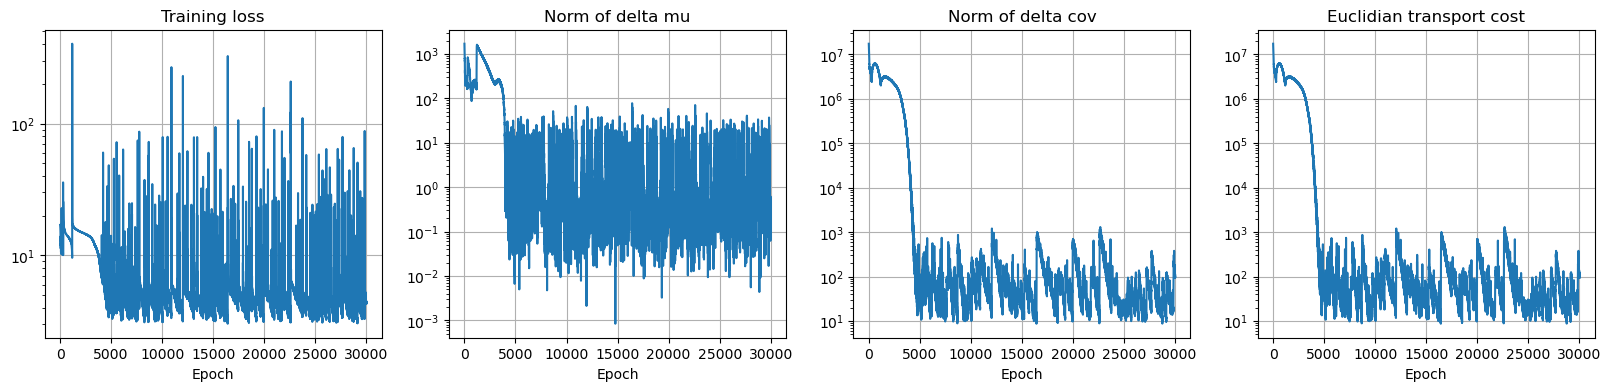

In [159]:
plot_metrics(losses, norms_delta_mu, norms_delta_cov, transport_costs)